In [9]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [10]:
# 1. Gather all image paths and labels
base_dir = '/kaggle/input/brain-tumor-classification-mri'
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')
classes = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']

# Collect all image paths and labels
all_images = []
all_labels = []
for cls in classes:
    # Training dir
    cls_dir = os.path.join(train_dir, cls)
    all_images += [os.path.join(cls_dir, fname) for fname in os.listdir(cls_dir) if fname.lower().endswith(('.png','.jpg','.jpeg'))]
    all_labels += [cls] * len([fname for fname in os.listdir(cls_dir) if fname.lower().endswith(('.png','.jpg','.jpeg'))])
    # Testing dir
    cls_dir = os.path.join(test_dir, cls)
    all_images += [os.path.join(cls_dir, fname) for fname in os.listdir(cls_dir) if fname.lower().endswith(('.png','.jpg','.jpeg'))]
    all_labels += [cls] * len([fname for fname in os.listdir(cls_dir) if fname.lower().endswith(('.png','.jpg','.jpeg'))])

all_images = np.array(all_images)
all_labels = np.array(all_labels)

In [11]:
# 60 train XG boost + PCA

# 35% test
X_temp, X_test, y_temp, y_test = train_test_split(
    all_images, all_labels, test_size=0.35, random_state=42, stratify=all_labels)

# 5% val (of total, so 0.05/0.65 ≈ 0.0769 of what's left)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.0769, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 1957, Val: 164, Test: 1143


In [12]:
# 3. Load and preprocess images
def load_and_preprocess_images(image_paths, target_size=(150, 150)):
    images = []
    for img_path in tqdm(image_paths):
        try:
            img = cv2.imread(img_path)
            img = cv2.resize(img, target_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return np.array(images)

print("Loading training images...")
X_train_images = load_and_preprocess_images(X_train)
print("Loading validation images...")
X_val_images = load_and_preprocess_images(X_val)
print("Loading test images...")
X_test_images = load_and_preprocess_images(X_test)

def flatten_and_normalize(images):
    n_samples = images.shape[0]
    h, w, c = images.shape[1], images.shape[2], images.shape[3]
    X_flat = images.reshape(n_samples, h*w*c).astype('float32') / 255.0
    return X_flat

X_train_flat = flatten_and_normalize(X_train_images)
X_val_flat = flatten_and_normalize(X_val_images)
X_test_flat = flatten_and_normalize(X_test_images)


Loading training images...


100%|██████████| 1957/1957 [00:07<00:00, 270.36it/s]


Loading validation images...


100%|██████████| 164/164 [00:00<00:00, 253.85it/s]


Loading test images...


100%|██████████| 1143/1143 [00:04<00:00, 272.69it/s]


In [13]:
# 4. PCA
n_components = 200  # You can tune this
print("Fitting PCA...")
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_flat)
X_val_pca = pca.transform(X_val_flat)
X_test_pca = pca.transform(X_test_flat)
print(f"PCA reduced to {n_components} components.")

Fitting PCA...
PCA reduced to 200 components.


In [14]:
# 5. Encode labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)
print(f"Class mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

Class mapping: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [15]:
# 6. Train XGBoost
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(label_encoder.classes_),
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    verbosity=1
)

print("Training XGBoost with PCA features...")
xgb_model.fit(
    X_train_pca, y_train_enc,
    eval_set=[(X_val_pca, y_val_enc)],
    early_stopping_rounds=20,
    verbose=True
)

Training XGBoost with PCA features...
[0]	validation_0-mlogloss:1.30607


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.23485
[2]	validation_0-mlogloss:1.18017
[3]	validation_0-mlogloss:1.11850
[4]	validation_0-mlogloss:1.06448
[5]	validation_0-mlogloss:1.02055
[6]	validation_0-mlogloss:0.98152
[7]	validation_0-mlogloss:0.94412
[8]	validation_0-mlogloss:0.91572
[9]	validation_0-mlogloss:0.88558
[10]	validation_0-mlogloss:0.85918
[11]	validation_0-mlogloss:0.83071
[12]	validation_0-mlogloss:0.80500
[13]	validation_0-mlogloss:0.78378
[14]	validation_0-mlogloss:0.76538
[15]	validation_0-mlogloss:0.74484
[16]	validation_0-mlogloss:0.72782
[17]	validation_0-mlogloss:0.71114
[18]	validation_0-mlogloss:0.69831
[19]	validation_0-mlogloss:0.68031
[20]	validation_0-mlogloss:0.66423
[21]	validation_0-mlogloss:0.65104
[22]	validation_0-mlogloss:0.63480
[23]	validation_0-mlogloss:0.62704
[24]	validation_0-mlogloss:0.61524
[25]	validation_0-mlogloss:0.60409
[26]	validation_0-mlogloss:0.59289
[27]	validation_0-mlogloss:0.58386
[28]	validation_0-mlogloss:0.57506
[29]	validation_0-mlogloss:0.

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

Evaluating...

XGBOOST RESULTS
Training Accuracy: 1.0000 (100.00%)
Validation Accuracy: 0.8598 (85.98%)
Test Accuracy: 0.8206 (82.06%)

Classification Report (Test):
                  precision    recall  f1-score   support

    glioma_tumor       0.79      0.79      0.79       324
meningioma_tumor       0.76      0.77      0.76       328
        no_tumor       0.88      0.70      0.78       175
 pituitary_tumor       0.88      0.97      0.92       316

        accuracy                           0.82      1143
       macro avg       0.83      0.81      0.82      1143
    weighted avg       0.82      0.82      0.82      1143



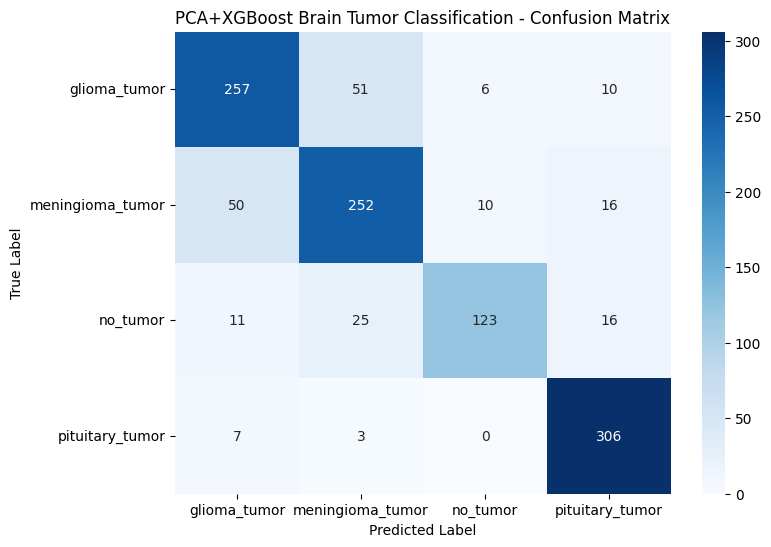

In [16]:
# 7. Evaluation
print("Evaluating...")
y_pred_train = xgb_model.predict(X_train_pca)
y_pred_val = xgb_model.predict(X_val_pca)
y_pred_test = xgb_model.predict(X_test_pca)

train_acc = accuracy_score(y_train_enc, y_pred_train)
val_acc = accuracy_score(y_val_enc, y_pred_val)
test_acc = accuracy_score(y_test_enc, y_pred_test)

print("\nXGBOOST RESULTS")
print(f"Training Accuracy: {train_acc:.4f} ({train_acc:.2%})")
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc:.2%})")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc:.2%})")

print("\nClassification Report (Test):")
print(classification_report(y_test_enc, y_pred_test, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test_enc, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('PCA+XGBoost Brain Tumor Classification - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()